In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from symbolic_pofk.pk_to_hmf import full_pipeline_hmf  
import joblib
import matplotlib.pyplot as plt



### Cleaning Traningset 


In [2]:
df = pd.read_csv("../symbolic_pofk/HMF_dataset_with_baryons_2000cp.csv")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()



array([[<Axes: title={'center': 'Cosmo_ID'}>,
        <Axes: title={'center': 'As'}>, <Axes: title={'center': 'Om'}>,
        <Axes: title={'center': 'Ob'}>],
       [<Axes: title={'center': 'h'}>, <Axes: title={'center': 'ns'}>,
        <Axes: title={'center': 'w0'}>, <Axes: title={'center': 'wa'}>],
       [<Axes: title={'center': 'A_SN1'}>,
        <Axes: title={'center': 'A_SN2'}>,
        <Axes: title={'center': 'A_AGN1'}>,
        <Axes: title={'center': 'A_AGN2'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'Mass'}>, <Axes: title={'center': 'Z'}>,
        <Axes: title={'center': 'Sigma'}>],
       [<Axes: title={'center': 'HMF'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

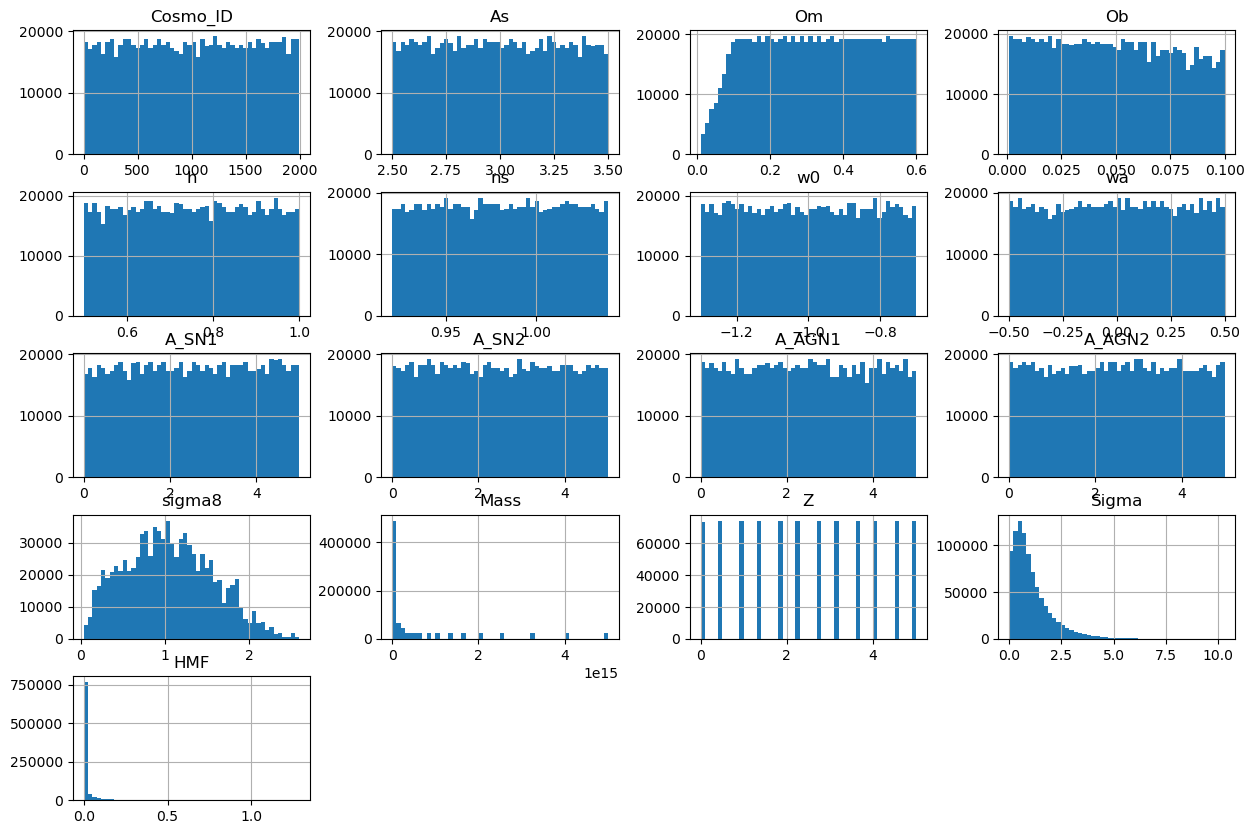

In [3]:
df.hist(bins=50, figsize=(15, 10))

### Neural Network 2108

#### Manipulation Data (HMF, Mass)

In [4]:
from sklearn.preprocessing import StandardScaler
X = df[["As","Om","Ob","h","ns","w0","wa","A_SN1","A_SN2","A_AGN1","A_AGN2","Mass","Z"]].copy()
y = df["HMF"].copy()

# --- Transform Mass ---
X["Mass"] = np.log10(X["Mass"]) 

# --- Transform HMF ---
eps = 1e-320  # Avoid log(0)
y_log = np.log10(y + eps)

# --- Scaling ---
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_log.values.reshape(-1,1))

array([[<Axes: title={'center': 'As'}>, <Axes: title={'center': 'Om'}>,
        <Axes: title={'center': 'Ob'}>, <Axes: title={'center': 'h'}>],
       [<Axes: title={'center': 'ns'}>, <Axes: title={'center': 'w0'}>,
        <Axes: title={'center': 'wa'}>,
        <Axes: title={'center': 'A_SN1'}>],
       [<Axes: title={'center': 'A_SN2'}>,
        <Axes: title={'center': 'A_AGN1'}>,
        <Axes: title={'center': 'A_AGN2'}>,
        <Axes: title={'center': 'Mass'}>],
       [<Axes: title={'center': 'Z'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

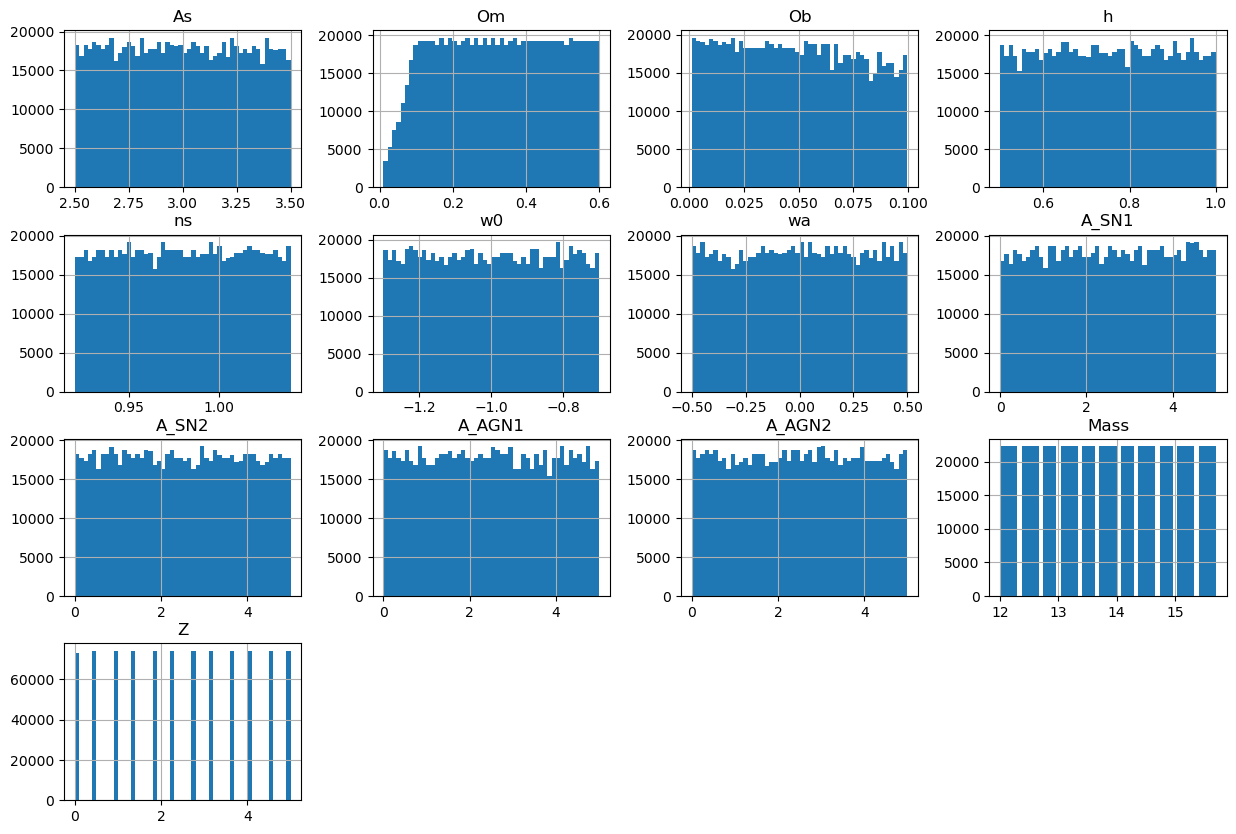

In [5]:
X.hist(bins=50, figsize=(15, 10))

#### Create Model (Keras)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

n_features = X_scaled.shape[1] 

model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',       # Mean Squared Error for regression
    metrics=['mae']   # Mean Absolute Error for following
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,713 (702.00 KB)

 Trainable params: 179,713 (702.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Train Model 


##### Split Data (Train 80%, Test 10%, Validation 10%)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


##### Train Model 

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=1024,       #big dataset -> big batch too
    verbose=1
)

Epoch 1/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2513 - mae: 0.1741 - val_loss: 0.0417 - val_mae: 0.0783
Epoch 2/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0236 - mae: 0.0595 - val_loss: 0.0154 - val_mae: 0.0492
Epoch 3/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0123 - mae: 0.0433 - val_loss: 0.0099 - val_mae: 0.0374
Epoch 4/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0088 - mae: 0.0361 - val_loss: 0.0084 - val_mae: 0.0401
Epoch 5/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0066 - mae: 0.0311 - val_loss: 0.0057 - val_mae: 0.0288
Epoch 6/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0055 - mae: 0.0287 - val_loss: 0.0050 - val_mae: 0.0287
Epoch 7/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0044 - mae: 0.0259 - val_loss: 0.0043 - val_mae: 0.0250
Epoch 8/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0037 - mae: 0.0237 - val_loss: 0.0036 - val_mae: 0.0223
Epoch 9/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - lo

##### Evaluate on "Test set"

In [9]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")


Test Loss (MSE): 0.0006
Test MAE: 0.0104


##### predict and inverse transform

In [10]:
# Predict on test
y_pred_scaled = model.predict(X_test)

# Inverse scaling
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
y_true_log = scaler_y.inverse_transform(y_test)

# Transform to HMF real
eps = 1e-320
y_pred = np.power(10, y_pred_log) - eps
y_true = np.power(10, y_true_log) - eps


2784/2784 ━━━━━━━━━━━━━━━━━━━━ 2s 650us/step


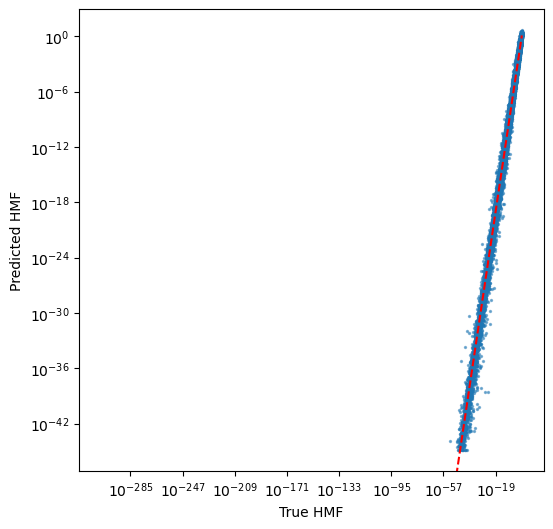

In [11]:


plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=2, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True HMF")
plt.ylabel("Predicted HMF")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [12]:
model.save("hmf_model.keras")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

c:\Users\MAIYP\anaconda3\envs\CosmoCNRS\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Relative error: median = 0.4625147984783231 , p90 = 0.8147497261634552
Log10 error (dex): median = 0.26963389507823865 , p90 = 0.7322503495781298 => median multiplicative factor ~ 1.860518081484618


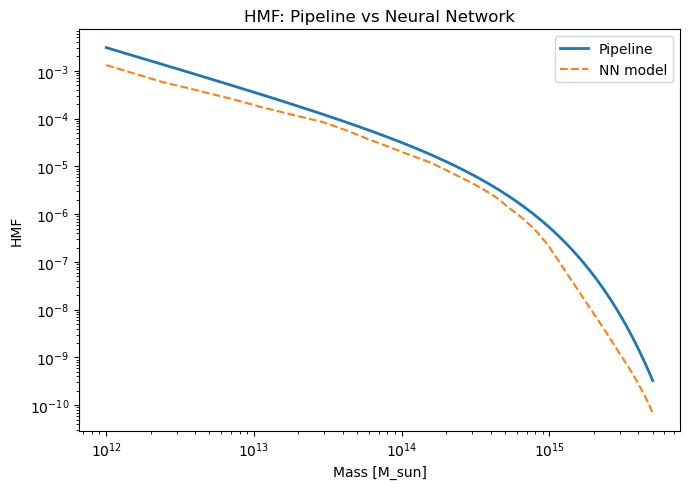

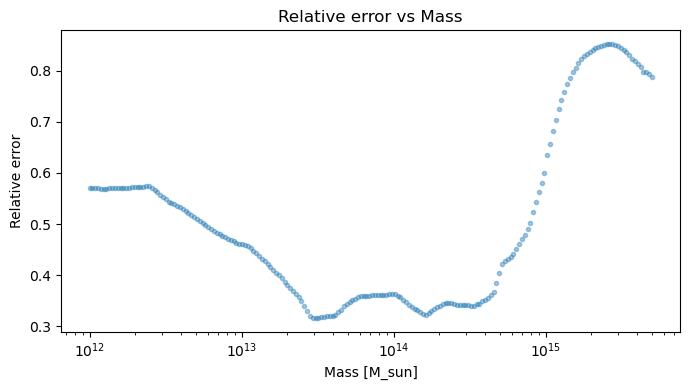

In [13]:
# compare_model_vs_pipeline.py
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---- 1) import pipeline
from symbolic_pofk.pk_to_hmf import full_pipeline_hmf

# ---- 2) Mass range: 1e12 -> 5e15
M_vals = np.logspace(12, np.log10(5e15), 200) 

# eps & tiny
EPS  = 1e-20
TINY = 1e-20

# ---- 3) Lim Param
PARAM_BOUNDS = {
    "As":   (2.5, 3.5),
    "Om":   (0.0, 0.6),
    "Ob":   (0.0, 0.10),
    "h":    (0.5, 1.0),
    "ns":   (0.90, 1.00),
    "w0":   (-1.2, -0.8),
    "wa":   (-0.5, 0.5),
    "A_SN1":  (1e-5, 5.0),
    "A_SN2":  (1e-5, 5.0),
    "A_AGN1": (1e-5, 5.0),
    "A_AGN2": (1e-5, 5.0),
    "Z":    (0.0, 5.0),
}

def check_bounds(params):
    for k, (lo, hi) in PARAM_BOUNDS.items():
        v = params[k]
        if not (lo <= v <= hi):
            raise ValueError(f"{k}={v} outlier limit [{lo}, {hi}].")

# ---- 4) Saisir params
params = {
    "As": 3.05, "Om": 0.32, "Ob": 0.049, "h": 0.67, "ns": 0.965,
    "w0": -1.0, "wa": 0.0,
    "A_SN1": 2.0, "A_SN2": 2.0, "A_AGN1": 2.0, "A_AGN2": 2.0,
    "Z": 0.0
}
check_bounds(params)

# ---- 5) HMF's PIPELINE
hmf_pipe, sigma_vals, sigma8 = full_pipeline_hmf(
    params["As"], params["Om"], params["Ob"], params["h"], params["ns"],
    params["w0"], params["wa"],
    params["A_SN1"], params["A_SN2"], params["A_AGN1"], params["A_AGN2"],
    z=params["Z"],
    baryon_effect=True,  
    M_vals=M_vals
)

# ---- 6) HMF's MODEL (load model + scaler as train)
model = load_model("hmf_model.keras")      
scaler_X = joblib.load("scaler_X.pkl")
scaler_y = joblib.load("scaler_y.pkl")

#  feature matrix for NN:
#   [As,Om,Ob,h,ns,w0,wa,A_SN1,A_SN2,A_AGN1,A_AGN2,Mass,Z]
# Each Mass in M_vals, repeat the cosmo params
n = len(M_vals)
X_nn = np.column_stack([
    np.full(n, params["As"]),
    np.full(n, params["Om"]),
    np.full(n, params["Ob"]),
    np.full(n, params["h"]),
    np.full(n, params["ns"]),
    np.full(n, params["w0"]),
    np.full(n, params["wa"]),
    np.full(n, params["A_SN1"]),
    np.full(n, params["A_SN2"]),
    np.full(n, params["A_AGN1"]),
    np.full(n, params["A_AGN2"]),
    M_vals,
    np.full(n, params["Z"]),
])

# apply transform as train:
#  - Mass -> log10
#  - Scaling feature using scaler_X
X_df_like = X_nn.copy()
# Mass's index 11
X_df_like[:, 11] = np.log10(X_df_like[:, 11])
X_scaled = scaler_X.transform(X_df_like)

# Predict (y has normalized in log10(HMF+eps))
y_scaled_pred = model.predict(X_scaled, verbose=0)
y_log_pred    = scaler_y.inverse_transform(y_scaled_pred)
hmf_pred      = np.maximum(10**y_log_pred.flatten() - EPS, 0.0)

# ---- 7) Compare
mask_finite = np.isfinite(hmf_pipe) & np.isfinite(hmf_pred)
denom = np.maximum(np.abs(hmf_pipe[mask_finite]), TINY)
rel_err = np.abs(hmf_pred[mask_finite] - hmf_pipe[mask_finite]) / denom

# log-error (dex) 
dex_err = np.abs(np.log10(hmf_pred[mask_finite] + EPS) -
                 np.log10(hmf_pipe[mask_finite] + EPS))

print("Relative error: median =", np.median(rel_err),
      ", p90 =", np.percentile(rel_err, 90))
print("Log10 error (dex): median =", np.median(dex_err),
      ", p90 =", np.percentile(dex_err, 90),
      "=> median multiplicative factor ~", 10**np.median(dex_err))

# ---- 8) Plot Mass compare
plt.figure(figsize=(7,5))
plt.loglog(M_vals, hmf_pipe, label="Pipeline", linewidth=2)
plt.loglog(M_vals, hmf_pred, label="NN model", linestyle="--")
plt.xlabel("Mass [M_sun]")
plt.ylabel("HMF")
plt.title("HMF: Pipeline vs Neural Network")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 9) 
plt.figure(figsize=(7,4))
plt.semilogx(M_vals[mask_finite], rel_err, marker='.', linestyle='none', alpha=0.4)
plt.xlabel("Mass [M_sun]")
plt.ylabel("Relative error")
plt.title("Relative error vs Mass")
plt.tight_layout()
plt.show()



### 🔧 Improved training block for ~5% relative error

This adds:
- BatchNorm + small Dropout for stability
- Learning-rate schedule and longer training
- Custom **MAPE on HMF (linear scale)** as training metric/loss (computed from the *scaled log(HMF)* target)
- Model checkpoints


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# --- Recover scaler parameters for inverse-transform inside loss/metric
mean_y = tf.constant(float(scaler_y.mean_[0]), dtype=tf.float32)
std_y  = tf.constant(float(scaler_y.scale_[0]), dtype=tf.float32)

EPS = tf.constant(1e-30, dtype=tf.float32)

def _invscale_log(y_scaled):
    # y_scaled -> unscaled log10(HMF)
    return y_scaled * std_y + mean_y

def _to_hmf(y_log):
    # log10(HMF) -> HMF (linear)
    return tf.pow(10.0, y_log)

@tf.function
def mape_on_hmf(y_true_scaled, y_pred_scaled):
    y_true_log = _invscale_log(y_true_scaled)
    y_pred_log = _invscale_log(y_pred_scaled)
    y_true = _to_hmf(y_true_log)
    y_pred = _to_hmf(y_pred_log)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + EPS)))

@tf.function
def hybrid_loss(y_true_scaled, y_pred_scaled):
    # Combine MSE in (scaled log) + MAPE in linear HMF
    mse = tf.reduce_mean(tf.square(y_true_scaled - y_pred_scaled))
    mape = mape_on_hmf(y_true_scaled, y_pred_scaled)
    return 0.5 * mse + 0.5 * mape


In [ ]:

tf.keras.backend.clear_session()

n_features = X_scaled.shape[1]
model2 = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.05),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(optimizer=opt, loss=hybrid_loss, metrics=[mape_on_hmf])

model2.summary()


In [ ]:

ckpt_cb = callbacks.ModelCheckpoint("hmf_model_mape_best.keras", save_best_only=True, monitor="val_mape_on_hmf", mode="min")
es_cb   = callbacks.EarlyStopping(patience=25, restore_best_weights=True, monitor="val_mape_on_hmf", mode="min")
rlr_cb  = callbacks.ReduceLROnPlateau(monitor="val_mape_on_hmf", mode="min", factor=0.5, patience=8, min_lr=1e-6, verbose=1)

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=2048,
    callbacks=[ckpt_cb, es_cb, rlr_cb],
    verbose=1
)


In [ ]:

# Evaluate on test with relative error metric (linear HMF)
test_mape = model2.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test relative error (MAPE on HMF): {test_mape*100:.2f}%")

# Predictions
y_pred2_scaled = model2.predict(X_test, verbose=0)
y_pred2_log = scaler_y.inverse_transform(y_pred2_scaled)
y_true2_log = scaler_y.inverse_transform(y_test)

y_pred2 = np.power(10.0, y_pred2_log) - 1e-320
y_true2 = np.power(10.0, y_true2_log) - 1e-320

rel_err = np.abs((y_pred2 - y_true2) / (y_true2 + 1e-30)).ravel()
print(f"Median rel. error: {np.median(rel_err)*100:.2f}% | 95th pct: {np.percentile(rel_err,95)*100:.2f}%")


In [ ]:

# Save artifacts
model2.save("hmf_model_mape.keras")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")
print("Saved: hmf_model_mape.keras, scaler_X.pkl, scaler_y.pkl")


In [ ]:

# Optional: compare vs pipeline on a mass grid (requires your pipeline module available)
try:
    from symbolic_pofk.pk_to_hmf import full_pipeline_hmf
    import matplotlib.pyplot as plt

    # Example: take median cosmology + baryon params from your df to seed a test row
    cosmo_cols = ["As","Om","Ob","h","ns","w0","wa","A_SN1","A_SN2","A_AGN1","A_AGN2","Z"]
    test_params = df[cosmo_cols].median().to_dict()

    M_vals = np.logspace(12, np.log10(5e15), 200)
    X_grid = []
    for M in M_vals:
        row = [test_params["As"], test_params["Om"], test_params["Ob"], test_params["h"], test_params["ns"],
               test_params["w0"], test_params["wa"], test_params["A_SN1"], test_params["A_SN2"],
               test_params["A_AGN1"], test_params["A_AGN2"], M, test_params["Z"]]
        X_grid.append(row)
    X_grid = np.array(X_grid)

    X_grid_df = pd.DataFrame(X_grid, columns=["As","Om","Ob","h","ns","w0","wa","A_SN1","A_SN2","A_AGN1","A_AGN2","Mass","Z"])
    X_grid_df["Mass"] = np.log10(X_grid_df["Mass"])

    X_grid_scaled = scaler_X.transform(X_grid_df.values)
    y_grid_scaled = model2.predict(X_grid_scaled, verbose=0)
    y_grid_log = scaler_y.inverse_transform(y_grid_scaled)
    hmf_nn = np.power(10.0, y_grid_log).ravel()

    # Pipeline result
    hmf_pipe = full_pipeline_hmf(
        As=test_params["As"], Om=test_params["Om"], Ob=test_params["Ob"], h=test_params["h"], ns=test_params["ns"],
        w0=test_params["w0"], wa=test_params["wa"], A_SN1=test_params["A_SN1"], A_SN2=test_params["A_SN2"],
        A_AGN1=test_params["A_AGN1"], A_AGN2=test_params["A_AGN2"],
        M=M_vals, z=test_params["Z"]
    )

    mask = np.isfinite(hmf_pipe) & (hmf_pipe>0) & np.isfinite(hmf_nn) & (hmf_nn>0)
    rel = np.abs((hmf_nn[mask] - hmf_pipe[mask])/(hmf_pipe[mask] + 1e-30))

    print(f"Grid compare → median rel%: {np.median(rel)*100:.2f} | 95th pct: {np.percentile(rel,95)*100:.2f}")

    plt.figure(figsize=(7,5))
    plt.loglog(M_vals[mask], hmf_pipe[mask], label="Pipeline")
    plt.loglog(M_vals[mask], hmf_nn[mask], label="Neural Net", alpha=0.7)
    plt.xlabel("Mass [M_sun]"); plt.ylabel("HMF")
    plt.title("HMF: Pipeline vs Neural Net")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.semilogx(M_vals[mask], rel*100.0, ".", alpha=0.4)
    plt.xlabel("Mass [M_sun]"); plt.ylabel("Rel. error [%]")
    plt.title("Relative error vs Mass")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Pipeline comparison skipped:", e)
